In [2]:
# Importing Libraries
import pandas as pd
import numpy as np

import nltk

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer

from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation
from gensim.parsing.porter import PorterStemmer

from gensim.models import Word2Vec

from sklearn.cluster import MiniBatchKMeans, KMeans

from sklearn.manifold import TSNE

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.preprocessing import MinMaxScaler

from sklearn import metrics

ModuleNotFoundError: No module named 'gensim'

In [3]:
# Cluster variance
def var_cluster(X, labels, n_cluster):
    dict_cluster = {'variance': X, 'cluster': labels}
    data_cluster = pd.DataFrame(data=dict_cluster)

    cluster_variance = []
    n = []

    for i in range(n_cluster):
        cl = data_cluster.loc[data_cluster['cluster'] == i]
        cl = np.array(cl['variance'])
        cl_var = np.var(cl, axis=0).mean()
        cluster_variance.append(cl_var)
        n.append(i)
    dict_var = {'cluster':n, 'variance':cluster_variance}
    return pd.DataFrame(data=dict_var)

In [4]:
# Remove empty headlines
def remove_empty(corpus):
    while '' in corpus:
        corpus.remove('')
    return corpus

In [5]:
# Get most frequent words of n-grams
def most_freq_words(n_gram, corpus, labels, n_cluster, num_words):
    dict_cluster = {'sentences': corpus, 'cluster': labels}
    data_cluster = pd.DataFrame(data=dict_cluster)

    m_words = []
    n = []

    for i in range(n_cluster):
        cl = data_cluster.loc[data_cluster['cluster'] == i]
        cl = np.array(cl['sentences'])
        cl_count = CountVectorizer(ngram_range=(n_gram, n_gram), token_pattern=r'\b\w+\b', 
                                   analyzer= 'word', max_features=num_words)
        cl_count.fit_transform(cl)
        words = [key for key in cl_count.vocabulary_]
        m_words.append(words)
        n.append(i)
    dict_most_freq = {'cluster':n, 'most frequent words':m_words}
    return pd.DataFrame(data=dict_most_freq)

In [6]:
# Separating per years in list
def sep_years(data, initial_year=2003, final_year=2017):
    years = np.arange(initial_year,final_year+1)
    data_years = [data[data['publish_date']//10000 == year] for year in years]

    return data_years

In [7]:
# Process raw text (remove stop words, remove punctuation and get root of words)
def process_text(data):
    p = PorterStemmer()
    data = [p.stem_sentence(strip_punctuation(remove_stopwords(sentence))) for sentence in data]
    return data

In [8]:
# Reading Data
data = pd.read_csv('Data/news_headlines.csv')

In [140]:
# Showing head of data frame
data.head()

,publish_date,headline_text
0,20030303,unhooked brakes to blame for taiwan train disa...
1,20030918,oldest prisoner in tas released citing health
2,20030913,nine reportedly dead in portuguese plane crash
3,20031031,nurses welcome medicare rebate plan
4,20030930,un cuts its iraq staff


In [141]:
# Dropping duplicated -> headline_text
data = data.drop_duplicates(['headline_text'])

In [142]:
data = sep_years(data,2009,2011)[2]

corpus = data['headline_text']
corpus = process_text(corpus)
corpus = remove_empty(corpus)

In [10]:
# N-Gram Feature Extractor

d_max = .3
d_min = 1

vect_2gram = TfidfVectorizer(ngram_range=(2, 2), token_pattern=r'\b\w+\b',
                             max_df=d_max, min_df=d_min, analyzer= 'word', max_features=300)
vect_3gram = TfidfVectorizer(ngram_range=(3, 3), token_pattern=r'\b\w+\b',
                             max_df=d_max, min_df=d_min, analyzer= 'word', max_features=300)
vect_4cgram = TfidfVectorizer(ngram_range=(4, 4), token_pattern=r'\b\w+\b',
                              max_df=d_max, min_df=d_min, analyzer= 'char', max_features=300)

#X_2 = vect_2gram.fit_transform(corpus)
#X_3 = vect_3gram.fit_transform(corpus)
X_4 = vect_4cgram.fit_transform(corpus)

#X_2_analyze = vect_2gram.build_analyzer()
#X_3_analyze = vect_3gram.build_analyzer()
X_4_analyze = vect_4cgram.build_analyzer()

#print('2gram', X_2_analyze('Bi-grams are cool!'))
#print('3gram', X_3_analyze('Bi-grams are cool!'))
print('4cgram', X_4_analyze('Bi-grams are cool!'))

#print(np.shape(X_2))
#print(np.shape(X_3))
print(np.shape(X_4))

4cgram ['bi-g', 'i-gr', '-gra', 'gram', 'rams', 'ams ', 'ms a', 's ar', ' are', 'are ', 're c', 'e co', ' coo', 'cool', 'ool!']
(643696, 300)


In [143]:
corpus_token = [[word for word in corpu.split()] for corpu in corpus]

model = Word2Vec(corpus_token, min_count=1, size = 200)

In [144]:
X = []
X_sentence = []

i = 0                
                
for sentence_token in corpus_token:
    print(i, end ='\r')
    i += 1
    for token in sentence_token:
        X_sentence.append(model.wv[token])
    feat_mean = np.average(X_sentence, axis=0)
    X.append(feat_mean/np.max(feat_mean))
    X_sentence = []

test


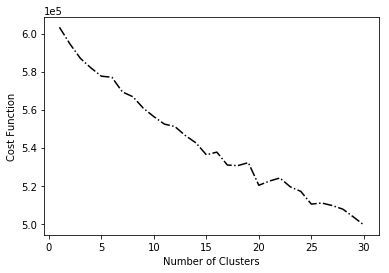

In [11]:
n_clusters = 30
lst_clust = []
cost_function = []

X = [X_4]

lst_clust = np.arange(1,n_clusters+1)
y_final = []

trace = ['k-.']
chart_name = ['4-char-gram']

for j in range(len(X)):
    for i in range(1, n_clusters+1):
        print(i ,end='\r')
        km = KMeans(n_clusters=i, init='k-means++', max_iter=100)
        km.fit(X[j])
        cost_function.append(km.inertia_)
    y_final.append(cost_function)
    cost_function = []
    print('test')
    plt.figure()
    fig, ax = plt.subplots()
    ax.plot(lst_clust, y_final[0], trace[j], label=chart_name[j])
    ax.yaxis.get_major_formatter().set_powerlimits((0, 1))

    plt.ylabel('Cost Function')
    plt.xlabel('Number of Clusters')
    plt.savefig(chart_name[j])

In [78]:
n_clusters  = 30
lst_clust = []
cost_function = []
metric = []



for i in range(2, n_clusters+1):
    print(i ,end='\r')
    km = MiniBatchKMeans(n_clusters=i, init='k-means++',n_init=1, max_iter=100)
    km.fit(X)
    metric.append(metrics.silhouette_score(X, km.labels_,sample_size=3000))
    lst_clust.append(i)
    cost_function.append(km.inertia_)

In [46]:
a_2009 = cost_function
m_2009 = metric

In [54]:
a_2010 = cost_function
m_2010 = metric

In [62]:
a_2011 = cost_function
m_2011 = metric

(29,) (29,)


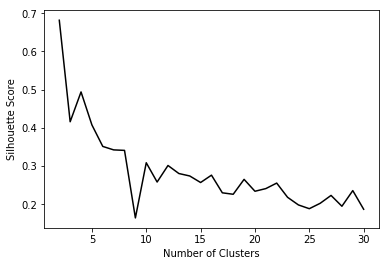

In [79]:
print(np.shape(lst_clust), np.shape(m_2009))

fig, ax = plt.subplots()
ax.plot(lst_clust, m_2009, 'k-')
#ax.plot(lst_clust, m_2010, 'k--', label='Year 2010')
#ax.plot(lst_clust, m_2011, 'k-.', label='Year 2011')

#legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

#ax.yaxis.get_major_formatter().set_powerlimits((0, 1))

plt.ylabel('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.savefig('wordembed')

In [145]:
clust_otimo = 7

km = MiniBatchKMeans(n_clusters=clust_otimo, init='k-means++',n_init=10, max_iter=100)
km.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=7,
        n_init=10, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [149]:
t = most_freq_words(n_gram=3,corpus=corpus,labels=km.labels_,n_cluster=clust_otimo, num_words=5)

with open('most_freq_word2vec_2011_3gram', 'w') as file:
    file.write(str(np.array(t)))

In [147]:
# Variance of cluster
b= var_cluster(X, km.labels_, clust_otimo)

with open('var_2011', 'w') as file:
    file.write(str(b))